To do list and doubts:

- aumentar o tamanho do dataset do RJ usando o scrap_v3
- usar label encoder ou onehotencoder?
- matriz de correlação, apesar dos valores estarem grandes em algumas colunas, não acredito que a gente deve tirar algo por conta disso.
- usei muitos fills para consertar as colunas mistas (existem colunas mistas no sentido de que são mistura entre int, float e str (usualmente são valores 'normal' escrito))
    - substitui os valores que são 'normal' para valores medianos para dar fill e ficar a coluna somente com um tipo de variável
- as colunas que são relacionadas a 'preço' são normalmente erradas em termos naturais, "listing.pricingInfo.yearlyIptu", "listing.pricingInfo.rentalPrice", "listing.pricingInfo.monthlyCondoFee". Uma normalização apenas resolveria isso? Talvez sim, mas fico em duvida sobre a realidade dos valores, pois por exemplo listing.pricingInfo.monthlyCondoFee varia entre 1.0 a 990.0, mas faz sentido ser esses valores?
- testar tecnicas de normalização (normalização ou padronização dos dados depois de transformar as colunas categoricas em numericas)

In [180]:
import pandas as pd
import numpy as np
import nb_black
import os
import warnings
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    mean_absolute_error,
)

from sklearn.linear_model import LinearRegression

warnings.filterwarnings("ignore")

%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


## Métodos

Essa secao ficara todos os metodos e funçoes que serao utilizadas no projeto, a fim de deixar mais organizado e limpo para facilitar o entendimento

In [3]:
def print_shape_dfs(folder_path):
    files = os.listdir(folder_path)
    csv_files = [f for f in files if f.endswith(".csv")]

    for file in csv_files:
        filepath = os.path.join(folder_path, file)
        df = pd.read_csv(filepath, delimiter=";")
        print(f"{file} -> {df.shape}")

In [4]:
def concat_csv_files(folder_path):
    files = os.listdir(folder_path)
    csv_files = [f for f in files if f.endswith(".csv")]
    print_shape_dfs(folder_path)

    dfs = []
    for file in csv_files:
        filepath = os.path.join(folder_path, file)
        temp_df = pd.read_csv(filepath, delimiter=";")
        dfs.append(temp_df)

    df_kaggle = pd.read_csv("dataZAP.csv", delimiter=";")
    dfs.append(df_kaggle)

    all_columns = set().union(*[set(df.columns) for df in dfs])
    dfs = [df.reindex(columns=all_columns) for df in dfs]

    result = pd.concat(dfs, ignore_index=True)
    output_file = os.path.join("./", "dataZap_concatenated.csv")
    result.to_csv(output_file, sep=";", index=False)
    print(f"Shape do df inicial: {df_kaggle.shape}\nShape do df final: {result.shape}")

In [5]:
def check_columns(df):
    check = []
    for column in df.columns:
        types = df[column].apply(type).unique()
        if len(types) > 1:
            if pd.api.types.is_numeric_dtype(df[column]):
                try:
                    converted = pd.to_numeric(df[column], errors="raise")
                except ValueError:
                    check.append(column)
            else:
                check.append(column)

    return check

In [6]:
def remove_outliers(df, num_columns):
    for column in num_columns:
        Q1 = np.percentile(df[column], 25)
        Q3 = np.percentile(df[column], 75)
        IQR = Q3 - Q1

        threshold = 1.5
        lower_limit = Q1 - threshold * IQR
        upper_limit = Q3 + threshold * IQR

        df = df[(df[column] > lower_limit) & (df[column] < upper_limit)]

    return df

In [147]:
def encode_categorical_columns(dataframe, cat_columns):
    encoded_df = dataframe.copy()

    for column in cat_columns:
        encoded_columns = pd.get_dummies(dataframe[column], prefix=column)
        encoded_df = pd.concat([encoded_df, encoded_columns], axis=1)
        encoded_df.drop(column, axis=1, inplace=True)

    return encoded_df

In [169]:
def standardize_columns(dataframe, target_column):
    standardized_df = dataframe.copy()

    num_columns = dataframe.select_dtypes(include="number").columns.drop(target_column)
    scaler = StandardScaler()
    standardized_columns = scaler.fit_transform(dataframe[num_columns])
    standardized_df[num_columns] = standardized_columns

    return standardized_df

## Webscraping

### Pre-Incrementação

Essa análise abaixo foi necessária para que nosso script de webscraping tenha as mesmas colunas e formato do dataset que está no kaggle, então abaixo foi feito uma análise sobre o shape deles e também sobre quais colunas tem em um e que não tem no outro, até que se chegou no ponto final, que é quando as duas tem o mesmo shape e colunas iguais, que é o output dessa parte.

Isso impactou no código scrap_zap_v3 (nossa versão), pois tive que modificar as colunas que são filtradas e consequentemente criadas o dataframe.

dfc = dataset do kaggle

dfx = um dos datasets que o webscraping cria

In [6]:
df = pd.read_csv("dataZAP.csv", delimiter=";")
df.shape

(35772, 78)

In [7]:
df_aux = pd.read_csv(
    "webscraping-datasets/dataZap_ce_aluguel_casas_TODOS_3.csv", delimiter=";"
)
df_aux.shape

(352, 78)

In [8]:
dfc = []
for i in df.columns:
    dfc.append(i)

dfx = []
for i in df_aux.columns:
    dfx.append(i)

dfc = set(dfc)
dfx = set(dfx)

In [9]:
len(dfc.intersection(dfx))

78

In [10]:
list(dfc - dfx)

[]

In [11]:
list(dfx - dfc)

[]

Conclusao: Dessa forma final, todas os dataframes que forem realizados pelo webscraping terao as mesmas colunas e quantidades que o dataset do kaggle, facilitando a incrementacao dos dados via scraping.

### Utilização do Script de WebScraping

O site do ZAP tem uma 'proteção' http por scraping, então o excesso de requisições ele acaba bloqueando por alguns minutos para uma outra nova requisição 

In [1]:
!python ./webscraping/scrap_zap_v3.py

TODOS -> TODOS -> rj -> apartamentos -> 3

Criando o arquivo dataZAP_aluguel_apartamentos_TODOS.csv com os dados

Arquivo criado

Webscraping finalizado!
TODOS -> TODOS -> rj -> cobertura -> 3
https://www.zapimoveis.com.br/aluguel/cobertura/rj/3-quartos/?pagina=61&precoMinimo=100&precoMaximo=2000000


429

Criando o arquivo dataZAP_aluguel_cobertura_TODOS.csv com os dados

Arquivo criado

Webscraping finalizado!


### Incrementação do Dataset

In [7]:
concat_csv_files("webscraping-datasets")

dataZap_ba_aluguel_casas_TODOS_3.csv -> (495, 78)
dataZap_ce_aluguel_casas_TODOS_3.csv -> (352, 78)
dataZap_es_aluguel_casas_TODOS_3.csv -> (106, 78)
dataZap_mg_aluguel_casas_TODOS_3.csv -> (1727, 78)
dataZap_rj_aluguel_apartamentos_TODOS_2.csv -> (8301, 78)
dataZap_rj_aluguel_apartamentos_TODOS_3.csv -> (4126, 78)
dataZap_rj_aluguel_apartamentos_TODOS_4.csv -> (1565, 78)
dataZap_rj_aluguel_apartamentos_TODOS_5.csv -> (107, 78)
dataZap_rj_aluguel_casas_TODOS_3.csv -> (1227, 78)
dataZap_rj_aluguel_casas_TODOS_5.csv -> (449, 78)
dataZap_rj_aluguel_cobertura_TODOS_2.csv -> (217, 78)
dataZap_rj_aluguel_cobertura_TODOS_3.csv -> (590, 78)
dataZap_rj_aluguel_cobertura_TODOS_4.csv -> (643, 78)
dataZap_sp_aluguel_casas_TODOS_3.csv -> (8900, 78)
Shape do df inicial: (35772, 78)
Shape do df final: (64577, 78)


## Data Science

### Pre-processamento

In [51]:
df = pd.read_csv("dataZap_concatenated.csv", delimiter=";")

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64577 entries, 0 to 64576
Data columns (total 78 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   listing.externalId                    64577 non-null  object 
 1   listing.guestpark                     64577 non-null  bool   
 2   listing.parkingSpaces                 63002 non-null  object 
 3   listing.pricingInfo.businessType      64577 non-null  object 
 4   listing.playground                    64577 non-null  bool   
 5   listing.subtitle                      64577 non-null  object 
 6   listing.link                          64577 non-null  object 
 7   listing.pricingInfo.yearlyIptu        56803 non-null  object 
 8   listing.createdAt                     64577 non-null  object 
 9   account.licenseNumber                 57489 non-null  object 
 10  listing.address.point.lon             45712 non-null  object 
 11  listing.usageTy

In [53]:
df.describe()

listing.unitsOnTheFloor  listing.unitFloor    listing.id  \
count             64577.000000       64577.000000  6.457700e+04   
mean                  0.312015           0.426917  2.507029e+09   
std                   1.669723           1.945242  2.105493e+08   
min                   0.000000           0.000000  4.346026e+07   
25%                   0.000000           0.000000  2.480232e+09   
50%                   0.000000           0.000000  2.490048e+09   
75%                   0.000000           0.000000  2.616321e+09   
max                  52.000000         102.000000  2.632962e+09   

       listing.pricingInfo.rentalPrice  listing.bedrooms  
count                     64577.000000      64577.000000  
mean                        104.100266          2.558806  
std                         255.756548          1.097265  
min                           1.000000          0.000000  
25%                           2.000000          2.000000  
50%                           3.800000          3.000000  
75%                          10.000000          3.000000  
max                         999.000000         20.000000

In [54]:
df.head()

listing.externalId  listing.guestpark listing.parkingSpaces  \
0             CO562A              False                   2.0   
1             CA0218              False                   0.0   
2                741              False                   7.0   
3           JC C232C              False                   2.0   
4           JC 9E32C              False                   2.0   

  listing.pricingInfo.businessType  listing.playground  \
0                           RENTAL               False   
1                           RENTAL               False   
2                      RENTAL_SALE               False   
3                           RENTAL               False   
4                           RENTAL               False   

                listing.subtitle  \
0            Casa para alugar em   
1            Casa para alugar em   
2  Casa para alugar e comprar em   
3            Casa para alugar em   
4            Casa para alugar em   

                                        listing.link  \
0  /imovel/aluguel-casa-3-quartos-mobiliado-guara...   
1  /imovel/aluguel-casa-3-quartos-com-cozinha-naz...   
2  /imovel/venda-casa-3-quartos-pituba-salvador-b...   
3  /imovel/aluguel-casa-3-quartos-gleba-a-camacar...   
4  /imovel/aluguel-casa-3-quartos-gleba-a-camacar...   

  listing.pricingInfo.yearlyIptu         listing.createdAt  \
0                            NaN  2022-02-22T19:17:45.103Z   
1                          161.0  2023-04-26T00:14:08.546Z   
2                          260.0  2023-03-04T14:04:38.655Z   
3                            NaN  2023-05-03T17:57:41.709Z   
4                            NaN  2023-05-03T15:50:44.599Z   

  account.licenseNumber listing.address.point.lon listing.usageTypes  \
0                   NaN                       NaN        RESIDENTIAL   
1                   NaN                       NaN        RESIDENTIAL   
2            14268-J-BA                -38.451315        RESIDENTIAL   
3                   NaN                -38.329384        RESIDENTIAL   
4                   NaN                -38.332531        RESIDENTIAL   

   listing.pricingInfo.isSale                  listing.advertiserId  \
0                       False  04c372ee-f00e-7e39-3d53-90cfaa1a8ab2   
1                       False  01a3699f-cd61-1e5b-591e-a5b91c00fc7e   
2                        True  42074fd8-9c4d-fb59-a874-b1dcb90c6890   
3                       False  b06058a8-c7fb-d8c6-e941-0769665397ff   
4                       False  b06058a8-c7fb-d8c6-e941-0769665397ff   

   listing.unitsOnTheFloor listing.address.point.source  listing.hottub  \
0                        0                          NaN           False   
1                        0                          NaN           False   
2                        0                       GOOGLE           False   
3                        0                       GOOGLE           False   
4                        0                       GOOGLE           False   

   listing.preview listing.address.zipCode listing.usableAreas  \
0            False              42840492.0                 300   
1            False              40050330.0                 183   
2            False              41810680.0                 300   
3            False              42803860.0                 250   
4            False              42803818.0                 200   

  listing.totalAreas listing.legacyId  listing.sportcourt listing.unitTypes  \
0              900.0              NaN                True              HOME   
1              183.0              NaN               False              HOME   
2             1000.0              NaN               False              HOME   
3                NaN              NaN               False              HOME   
4                NaN              NaN               False              HOME   

   listing.backyard listing.publicationType  \
0             False           SUPER_PREMIUM   
1             False           SUPER_PREMIUM   
2          

In [55]:
df.isna().sum()

listing.externalId                     0
listing.guestpark                      0
listing.parkingSpaces               1575
listing.pricingInfo.businessType       0
listing.playground                     0
                                    ... 
listing.sauna                          0
listing.address.precision              0
listing.bedrooms                       0
listing.barbgrill                      0
listing.address.state                  0
Length: 78, dtype: int64

#### Analisando as colunas

In [56]:
columns = [
    "listing.pricingInfo.isRent",
    "listing.pricingInfo.isSale",
    "listing.pricingInfo.price",
    "listing.pricingInfo.rentalPrice",
    "listing.pricingInfo.rentalTotalPrice",
    "listing.pricingInfo.salePrice",
]
df[columns]

listing.pricingInfo.isRent  listing.pricingInfo.isSale  \
0                            True                       False   
1                            True                       False   
2                            True                        True   
3                            True                       False   
4                            True                       False   
...                           ...                         ...   
64572                        True                       False   
64573                        True                       False   
64574                        True                       False   
64575                        True                       False   
64576                        True                       False   

      listing.pricingInfo.price  listing.pricingInfo.rentalPrice  \
0                         3.000                             3.00   
1                         3.000                             3.00   
2                         7.500                             7.50   
3                         1.800                             1.80   
4                         1.800                             1.80   
...                         ...                              ...   
64572                       1.8                             1.80   
64573                      1.19                             1.19   
64574                     940.0                           940.00   
64575                       1.6                             1.60   
64576                       2.0                             2.00   

      listing.pricingInfo.rentalTotalPrice listing.pricingInfo.salePrice  
0                                      NaN                           NaN  
1                                      NaN                           NaN  
2                                      NaN                     1.300.000  
3                                      NaN                           NaN  
4                                      NaN                           NaN  
...                                    ...                           ...  
64572                                2.720                        normal  
64573                                1.434                        normal  
64574                                1.054                        normal  
64575                                2.294                        normal  
64576                                2.807                        normal  

[64577 rows x 6 columns]

In [57]:
df["listing.pricingInfo.rentalTotalPrice"].isna().sum()

13765

In [58]:
df["listing.pricingInfo.price"].isna().sum()

0

In [59]:
df[(df["listing.pricingInfo.isRent"] == True)]

listing.externalId  listing.guestpark listing.parkingSpaces  \
0                 CO562A              False                   2.0   
1                 CA0218              False                   0.0   
2                    741              False                   7.0   
3               JC C232C              False                   2.0   
4               JC 9E32C              False                   2.0   
...                  ...                ...                   ...   
64572          893106746              False                     1   
64573          893081971              False                     1   
64574          893103422              False                     0   
64575          893107326              False                     1   
64576          893104891              False                     0   

      listing.pricingInfo.businessType  listing.playground  \
0                               RENTAL               False   
1                               RENTAL               False   
2                          RENTAL_SALE               False   
3                               RENTAL               False   
4                               RENTAL               False   
...                                ...                 ...   
64572                           RENTAL                True   
64573                           RENTAL                True   
64574                           RENTAL               False   
64575                           RENTAL               False   
64576                           RENTAL               False   

                    listing.subtitle  \
0                Casa para alugar em   
1                Casa para alugar em   
2      Casa para alugar e comprar em   
3                Casa para alugar em   
4                Casa para alugar em   
...                              ...   
64572     Apartamento para alugar em   
64573     Apartamento para alugar em   
64574     Apartamento para alugar em   
64575     Apartamento para alugar em   
64576     Apartamento para alugar em   

                                            listing.link  \
0      /imovel/aluguel-casa-3-quartos-mobiliado-guara...   
1      /imovel/aluguel-casa-3-quartos-com-cozinha-naz...   
2      /imovel/venda-casa-3-quartos-pituba-salvador-b...   
3      /imovel/aluguel-casa-3-quartos-gleba-a-camacar...   
4      /imovel/aluguel-casa-3-quartos-gleba-a-camacar...   
...                                                  ...   
64572  /imovel/aluguel-apartamento-2-quartos-com-pisc...   
64573  /imovel/aluguel-apartamento-1-quarto-com-churr...   
64574  /imovel/aluguel-apartamento-1-quarto-caninde-c...   
64575  /imovel/aluguel-apartamento-3-quartos-com-elev...   
64576  /imovel/aluguel-apartamento-3-quartos-com-pisc...   

      listing.pricingInfo.yearlyIptu         listing.createdAt  \
0                                NaN  2022-02-22T19:17:45.103Z   
1                              161.0  2023-04-26T00:14:08.546Z   
2                              260.0  2023-03-04T14:04:38.655Z   
3                                NaN  2023-05-03T17:57:41.709Z   
4                                NaN  2023-05-03T15:50:44.599Z   
...                              ...                       ...   
64572                            142  2020-07-18T05:08:38.672Z   
64573                         normal  2020-06-25T22:15:37.893Z   
64574                         normal  2020-07-15T16:42:38.375Z   
64575                            251  2020-07-20T17:39:39.520Z   
64576                             99  2020-07-19T05:20:23.158Z   

      account.licenseNumber listing.address.point.lon listing.usageTypes  \
0                       NaN                       NaN        RESIDENTIAL   
1                       NaN                       NaN        RESIDENTIAL   
2                14268-J-BA                -38.451315        RESIDENTIAL   
3                       NaN                -38.329384        RESIDENTIAL   
4                       NaN                -38.332531    

In [60]:
df["listing.pricingInfo.businessType"].value_counts()

RENTAL         49276
RENTAL_SALE    13555
SALE_RENTAL     1746
Name: listing.pricingInfo.businessType, dtype: int64

In [61]:
df["listing.displayAddressType"].value_counts()

ALL             34986
STREET          19787
NEIGHBORHOOD     9804
Name: listing.displayAddressType, dtype: int64

In [62]:
df["listing.isInactive"].value_counts()

False    64018
True       559
Name: listing.isInactive, dtype: int64

In [63]:
df["listing.floors"].unique()  # Valores mistos que serão tratados

array([nan, 0.0, 1.0, 3.0, 2.0, 6.0, 12.0, 4.0, 17.0, 7.0, 8.0, 13.0,
       20.0, 10.0, 23.0, 15.0, 11.0, 14.0, 16.0, 5.0, 9.0, 24.0, 18.0,
       22.0, 19.0, 21.0, 25.0, 30.0, 29.0, 26.0, 28.0, 175.0, 71.0, 32.0,
       '0.0', '1.0', '12.0', '32.0', '22.0', '10.0', '28.0', '3.0', '2.0',
       '6.0', '14.0', '71.0', 'normal', '2', '21', '10', '13', '15', '12',
       '4', '20', '6', '8', '3', '11', '28', '23', '9', '16', '14', '24',
       '30', '5', '17', '22', '27', '19', '1', '7', '35', '18', '25',
       '26', '660', '175', '31', '32', '33'], dtype=object)

In [64]:
df["listing.totalAreas"].unique()  # Valores mistos que serão tratados

array([900.0, 183.0, 1000.0, ..., '1778', '3600', '1108'], dtype=object)

In [65]:
# Tirando as colunas que nao importam para nossa analise

columns = [
    "listing.address.streetNumber",
    "Page",
    "account.legacyVivarealId",
    "account.legacyZapId",
    "listing.address.geoJson",
    "account.licenseNumber",
    "listing.address.ibgeCityId",
    "listing.id",
    "listing.legacyId",
    "listing.pricingInfo.priceVariation",
    "listing.description",
    "listing.images",
    "listing.videos",
    "listing.pricingInfo.isRent",
    "listing.pricingInfo.isSale",
    "listing.pricingInfo.price",
    "listing.pricingInfo.rentalTotalPrice",
    "listing.pricingInfo.salePrice",
    "listing.unitSubTypes",
    "listing.amenities",
    "account.logoUrl",
    "account.name",
    "link.href",
    "listing.updatedAt",
    "listing.subtitle",
    "listing.title",
    "listing.portal",
    "listing.createdAt",
    "listing.externalId",
    "listing.advertiserId",
    "listing.address.zipCode",
    "listing.address.street",
    "listing.address.point.lon",
    "listing.address.point.lat",
    "listing.address.precision",
    "listing.videoTour",
    "listing.address.point.source",
    "listing.address.country",
    "listing.address.confidence",
    "listing.publicationType",
    "listing.pricingInfo.businessType",
    "listing.address.state",
    "listing.listingType",
    "listing.link",
    "listing.propertyType",
    "listing.pricingInfo.businessLabel",
    "listing.isInactive",
]

lista_columns = []
for df_columns in df.columns:
    lista_columns.append(df_columns)

for column in columns:
    if column in lista_columns:
        df.drop(columns=column, axis=1, inplace=True)

In [66]:
df.shape

(64577, 42)

#### Limitando a regiao de interesse

Consideramos que a regiao importa para o calculo do modelo de previsao. Entao para isso, iremos fazer um filtro para que a nossa previsao seja mais fidedigna possivel com os valores apresentados. Dessa forma, vamos fazer a analise do preço de aluguel para o estado do Rio de Janeiro

In [67]:
pd.options.display.max_columns = 99
column_filter = df["listing.address.city"] == "Rio de Janeiro"
df = df[column_filter]

In [68]:
df.isna().sum()

listing.guestpark                         0
listing.parkingSpaces                   983
listing.playground                        0
listing.pricingInfo.yearlyIptu         3027
listing.usageTypes                        0
listing.unitsOnTheFloor                   0
listing.hottub                            0
listing.preview                           0
listing.usableAreas                       0
listing.totalAreas                     1228
listing.sportcourt                        0
listing.unitTypes                         0
listing.backyard                          0
listing.partyhall                         0
listing.pricingInfo.period                0
listing.furnished                         0
listing.businessTypeContext               0
listing.address.neighborhood              0
listing.displayAddressType                0
listing.acceptExchange                    0
listing.unitFloor                         0
listing.address.zone                      0
listing.gym                     

In [69]:
df.head(1)

listing.guestpark listing.parkingSpaces  listing.playground  \
2680              False                   1.0               False   

     listing.pricingInfo.yearlyIptu listing.usageTypes  \
2680                            NaN        RESIDENTIAL   

      listing.unitsOnTheFloor  listing.hottub  listing.preview  \
2680                        0           False            False   

     listing.usableAreas listing.totalAreas  listing.sportcourt  \
2680                  54               54.0               False   

     listing.unitTypes  listing.backyard  listing.partyhall  \
2680         APARTMENT             False              False   

     listing.pricingInfo.period  listing.furnished  \
2680                        mês              False   

     listing.businessTypeContext listing.address.neighborhood  \
2680                      RENTAL                Rocha Miranda   

     listing.displayAddressType  listing.acceptExchange  listing.unitFloor  \
2680                        ALL                   False                  0   

     listing.address.zone  listing.gym listing.address.level  \
2680           Zona Norte        False                STREET   

     listing.address.city          type     imvl_type  \
2680       Rio de Janeiro  superPremium  apartamentos   

     listing.pricingInfo.monthlyCondoFee  listing.pricingInfo.rentalPrice  \
2680                                 235                            900.0   

      listing.tenniscourt  listing.mountainview listing.floors  \
2680                False                 False            NaN   

      listing.garden  listing.soundproofing  listing.bathtub  \
2680           False                  False            False   

     listing.bathrooms  listing.pool  listing.fireplace listing.suites  \
2680                 2         False              False            NaN   

      listing.sauna  listing.bedrooms  listing.barbgrill  
2680          False                 2              False

#### Completando (Fill) os valores nulos

In [70]:
# Como nao pode ter casa sem piso, sera transformado em 1 quando nulo
df["listing.floors"] = df["listing.floors"].fillna(1)

# Valor de iptu nula, deve ser sem iptu
df["listing.pricingInfo.yearlyIptu"] = df["listing.pricingInfo.yearlyIptu"].fillna(0)

# Vaga de estacionamento nula, deve ser sem vagas
df["listing.parkingSpaces"] = df["listing.parkingSpaces"].fillna(0)

# Area total nula, vamos admitir que é o mesmo tamanho da area usavel
df["listing.totalAreas"] = df["listing.totalAreas"].fillna(df["listing.usableAreas"])

In [71]:
df.isna().sum()

listing.guestpark                         0
listing.parkingSpaces                     0
listing.playground                        0
listing.pricingInfo.yearlyIptu            0
listing.usageTypes                        0
listing.unitsOnTheFloor                   0
listing.hottub                            0
listing.preview                           0
listing.usableAreas                       0
listing.totalAreas                        0
listing.sportcourt                        0
listing.unitTypes                         0
listing.backyard                          0
listing.partyhall                         0
listing.pricingInfo.period                0
listing.furnished                         0
listing.businessTypeContext               0
listing.address.neighborhood              0
listing.displayAddressType                0
listing.acceptExchange                    0
listing.unitFloor                         0
listing.address.zone                      0
listing.gym                     

In [72]:
df[df["listing.suites"].isna() == True][
    ["listing.bathrooms", "listing.bedrooms", "listing.suites"]
]

listing.bathrooms  listing.bedrooms listing.suites
2680                  2                 2            NaN
2688                  2                 2            NaN
2694                  2                 2            NaN
2697                  2                 2            NaN
2704                  2                 2            NaN
...                 ...               ...            ...
19566                 7                 5            NaN
19631                 8                 5            NaN
19689                 7                 5            NaN
19785                 4                 4            NaN
19841                 3                 5            NaN

[1363 rows x 3 columns]

In [73]:
df[["listing.bathrooms", "listing.bedrooms", "listing.suites"]]

listing.bathrooms  listing.bedrooms listing.suites
2680                  2                 2            NaN
2681                  2                 2            1.0
2682                  2                 2            1.0
2684                  2                 2            1.0
2687                  3                 2            1.0
...                 ...               ...            ...
64558                 1                 2              0
64564                 2                 3              1
64569                 3                 3              1
64570                 2                 1              0
64572                 2                 2              1

[15199 rows x 3 columns]

In [74]:
df = df.dropna(subset=["listing.suites"])

In [75]:
df.isna().sum()

listing.guestpark                         0
listing.parkingSpaces                     0
listing.playground                        0
listing.pricingInfo.yearlyIptu            0
listing.usageTypes                        0
listing.unitsOnTheFloor                   0
listing.hottub                            0
listing.preview                           0
listing.usableAreas                       0
listing.totalAreas                        0
listing.sportcourt                        0
listing.unitTypes                         0
listing.backyard                          0
listing.partyhall                         0
listing.pricingInfo.period                0
listing.furnished                         0
listing.businessTypeContext               0
listing.address.neighborhood              0
listing.displayAddressType                0
listing.acceptExchange                    0
listing.unitFloor                         0
listing.address.zone                      0
listing.gym                     

In [76]:
df[["type", "listing.pricingInfo.monthlyCondoFee"]]

type listing.pricingInfo.monthlyCondoFee
2681   superPremium                                 900
2682   superPremium                               3.200
2684        premium                               1.500
2687        premium                               1.293
2696            NaN                                 NaN
...             ...                                 ...
64558        normal                                 500
64564        normal                               1.296
64569       premium                                 968
64570       premium                                 480
64572       premium                                 920

[13836 rows x 2 columns]

In [77]:
df["type"].value_counts()

premium                3763
normal                 2338
superPremium            504
rankingSuperPremium     284
Name: type, dtype: int64

In [78]:
df[df.type == "premium"][["type", "listing.pricingInfo.rentalPrice"]]

type  listing.pricingInfo.rentalPrice
2684   premium                             3.25
2687   premium                             2.80
2700   premium                             3.80
2702   premium                             1.70
2703   premium                             2.80
...        ...                              ...
64546  premium                             1.40
64548  premium                             1.80
64569  premium                             4.70
64570  premium                             1.40
64572  premium                             1.80

[3763 rows x 2 columns]

In [79]:
df["type"] = df["type"].fillna("normal")

In [80]:
df["listing.pricingInfo.monthlyCondoFee"].value_counts()

normal    458
300       167
500       159
250       122
350       120
         ... 
2.007       1
3.208       1
2.006       1
2.32        1
3.120       1
Name: listing.pricingInfo.monthlyCondoFee, Length: 2977, dtype: int64

In [81]:
df[df["listing.pricingInfo.monthlyCondoFee"] == "normal"][
    [
        "listing.pricingInfo.monthlyCondoFee",
        "listing.pricingInfo.rentalPrice",
        "listing.bedrooms",
    ]
]

listing.pricingInfo.monthlyCondoFee  listing.pricingInfo.rentalPrice  \
28840                              normal                              3.1   
28898                              normal                              4.0   
28900                              normal                              3.0   
29283                              normal                              1.5   
29651                              normal                            250.0   
...                                   ...                              ...   
62887                              normal                             17.0   
63381                              normal                              4.7   
63399                              normal                              1.2   
63406                              normal                              1.2   
63503                              normal                             15.0   

       listing.bedrooms  
28840                 2  
28898                 2  
28900                 2  
29283                 1  
29651                 2  
...                 ...  
62887                 4  
63381                 2  
63399                 2  
63406                 2  
63503                 6  

[458 rows x 3 columns]

In [82]:
df["listing.totalAreas"] = pd.to_numeric(df["listing.totalAreas"], errors="coerce")
df["listing.totalAreas"].replace("normal", pd.NA, inplace=True)

df["listing.totalAreas"].fillna(df["listing.totalAreas"].median(), inplace=True)

In [83]:
df["listing.floors"].replace("normal", pd.NA, inplace=True)

df["listing.floors"].fillna(df["listing.floors"].median(), inplace=True)

In [84]:
df["listing.pricingInfo.yearlyIptu"] = pd.to_numeric(
    df["listing.pricingInfo.yearlyIptu"], errors="coerce"
)
df["listing.pricingInfo.yearlyIptu"].replace("normal", pd.NA, inplace=True)

df["listing.pricingInfo.yearlyIptu"].fillna(
    df["listing.pricingInfo.yearlyIptu"].median(), inplace=True
)

In [85]:
df["listing.suites"] = pd.to_numeric(df["listing.suites"], errors="coerce")
df["listing.suites"].replace("normal", pd.NA, inplace=True)

df["listing.suites"].fillna(df["listing.suites"].median(), inplace=True)

In [86]:
df["listing.parkingSpaces"] = pd.to_numeric(
    df["listing.parkingSpaces"], errors="coerce"
)
df["listing.parkingSpaces"].replace("normal", pd.NA, inplace=True)

df["listing.parkingSpaces"].fillna(df["listing.parkingSpaces"].median(), inplace=True)

In [87]:
df["listing.pricingInfo.monthlyCondoFee"].replace("normal", pd.NA, inplace=True)
df["listing.pricingInfo.monthlyCondoFee"] = df[
    "listing.pricingInfo.monthlyCondoFee"
].str.replace(".", "", regex=True)
df["listing.pricingInfo.monthlyCondoFee"] = pd.to_numeric(
    df["listing.pricingInfo.monthlyCondoFee"], errors="coerce"
).astype(float)
df["listing.pricingInfo.monthlyCondoFee"].fillna(
    df["listing.pricingInfo.monthlyCondoFee"].median(), inplace=True
)

In [88]:
df.isna().sum()

listing.guestpark                      0
listing.parkingSpaces                  0
listing.playground                     0
listing.pricingInfo.yearlyIptu         0
listing.usageTypes                     0
listing.unitsOnTheFloor                0
listing.hottub                         0
listing.preview                        0
listing.usableAreas                    0
listing.totalAreas                     0
listing.sportcourt                     0
listing.unitTypes                      0
listing.backyard                       0
listing.partyhall                      0
listing.pricingInfo.period             0
listing.furnished                      0
listing.businessTypeContext            0
listing.address.neighborhood           0
listing.displayAddressType             0
listing.acceptExchange                 0
listing.unitFloor                      0
listing.address.zone                   0
listing.gym                            0
listing.address.level                  0
listing.address.

In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13836 entries, 2681 to 64572
Data columns (total 42 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   listing.guestpark                    13836 non-null  bool   
 1   listing.parkingSpaces                13836 non-null  float64
 2   listing.playground                   13836 non-null  bool   
 3   listing.pricingInfo.yearlyIptu       13836 non-null  float64
 4   listing.usageTypes                   13836 non-null  object 
 5   listing.unitsOnTheFloor              13836 non-null  int64  
 6   listing.hottub                       13836 non-null  bool   
 7   listing.preview                      13836 non-null  bool   
 8   listing.usableAreas                  13836 non-null  object 
 9   listing.totalAreas                   13836 non-null  float64
 10  listing.sportcourt                   13836 non-null  bool   
 11  listing.unitTypes        

#### Definindo a questão de quais são as colunas categoricas e numéricas

In [90]:
df["listing.pricingInfo.yearlyIptu"] = df["listing.pricingInfo.yearlyIptu"].astype(
    float
)
df["listing.pricingInfo.monthlyCondoFee"] = df[
    "listing.pricingInfo.monthlyCondoFee"
].astype(float)

In [91]:
df["listing.bedrooms"] = df["listing.bedrooms"].astype(int)
df["listing.bathrooms"] = df["listing.bathrooms"].astype(int)
df["listing.usableAreas"] = df["listing.usableAreas"].astype(int)
df["listing.suites"] = df["listing.suites"].astype(int)

#### Manutenção dos outliers

In [92]:
len(df["listing.pricingInfo.rentalPrice"].unique())

1129

In [93]:
len(df["listing.pricingInfo.monthlyCondoFee"].unique())

2197

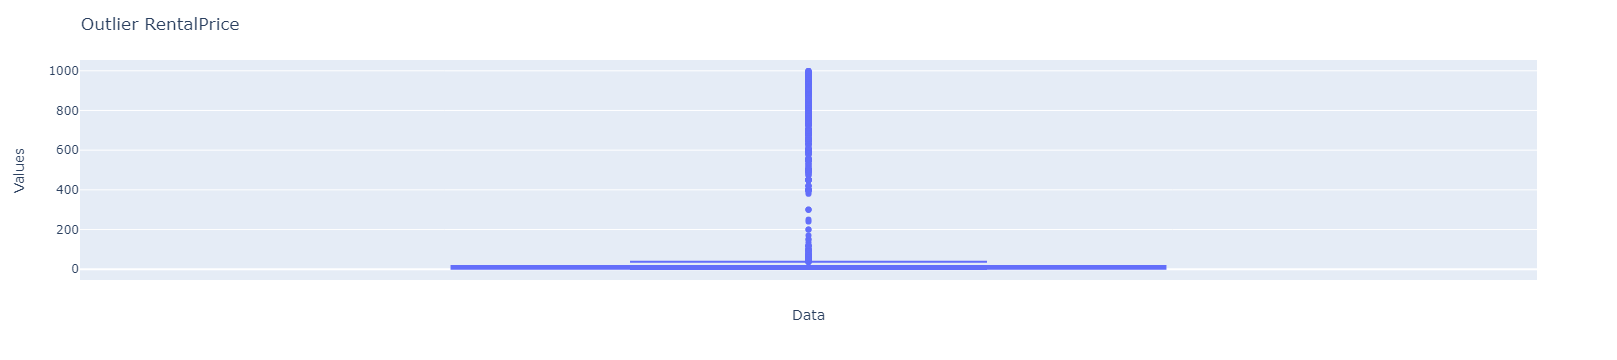

In [94]:
fig = px.box(
    df["listing.pricingInfo.rentalPrice"], y=df["listing.pricingInfo.rentalPrice"]
)
fig.update_layout(
    title="Outlier RentalPrice",
    xaxis=dict(title="Data"),
    yaxis=dict(title="Values"),
    boxmode="group",
    showlegend=False,
)
fig.show()

In [95]:
num_columns = [
    "listing.pricingInfo.rentalPrice",
    "listing.pricingInfo.yearlyIptu",
    "listing.usableAreas",
    "listing.totalAreas",
    "listing.pricingInfo.monthlyCondoFee",
]

df = remove_outliers(df, num_columns)

In [96]:
len(df["listing.pricingInfo.rentalPrice"].unique())

788

In [97]:
len(df["listing.pricingInfo.monthlyCondoFee"].unique())

1431

In [98]:
df[["listing.pricingInfo.monthlyCondoFee"]].sort_values(
    "listing.pricingInfo.monthlyCondoFee"
)

listing.pricingInfo.monthlyCondoFee
50522                                  1.0
5176                                   1.0
50547                                  1.0
6653                                   1.0
7798                                   1.0
...                                    ...
14266                               2445.0
15873                               2453.0
46779                               2461.0
15951                               2468.0
10886                               2471.0

[8795 rows x 1 columns]

#### Save

In [99]:
df.to_csv("./dataZap_final.csv", sep=";", index=False)

#### Selecionar as features baseada na correlação

In [171]:
df = pd.read_csv("dataZap_final.csv", delimiter=";")
df.shape

(8795, 42)

In [149]:
df.isna().sum()

listing.guestpark                      0
listing.parkingSpaces                  0
listing.playground                     0
listing.pricingInfo.yearlyIptu         0
listing.usageTypes                     0
listing.unitsOnTheFloor                0
listing.hottub                         0
listing.preview                        0
listing.usableAreas                    0
listing.totalAreas                     0
listing.sportcourt                     0
listing.unitTypes                      0
listing.backyard                       0
listing.partyhall                      0
listing.pricingInfo.period             0
listing.furnished                      0
listing.businessTypeContext            0
listing.address.neighborhood           0
listing.displayAddressType             0
listing.acceptExchange                 0
listing.unitFloor                      0
listing.address.zone                   0
listing.gym                            0
listing.address.level                  0
listing.address.

<Axes: >

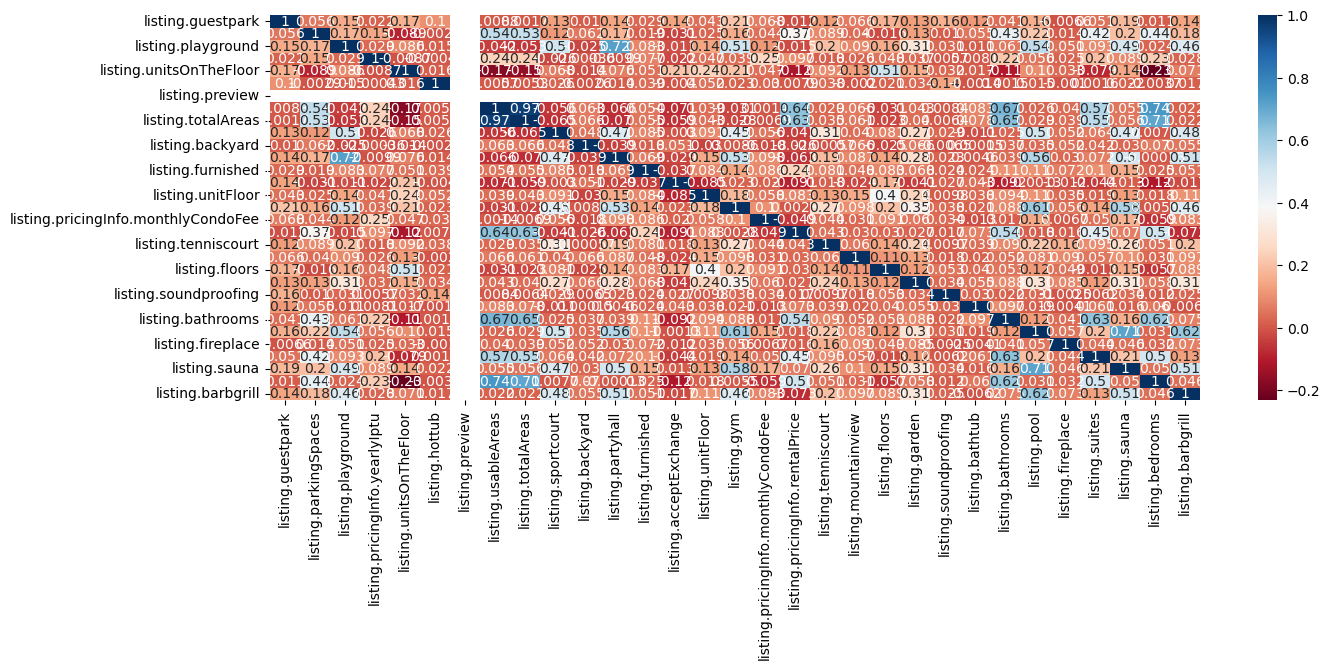

In [112]:
plt.subplots(figsize=(15, 5))
sns.heatmap(df.corr(), cmap="RdBu", cbar=True, annot=True)

Valores com uma correlação considerável:

- listing_sauna x listing pool
- listing.playground x listing.sportcourt
- listing.pricinginfo.rentalPrice x listing.bedrooms
- listing.bathtub x listing.hottub
- listing.partyhall x listing.playground
- listing.pool x listing.barbgrill

Apesar de alguns terem valores de correlação alto, não considero retirar algumas colunas pois elas podem existir mesmo que a outra não exista, então é importante deixar pois são características diferentes.

#### Categorico para numérico

In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8795 entries, 0 to 8794
Data columns (total 42 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   listing.guestpark                    8795 non-null   bool   
 1   listing.parkingSpaces                8795 non-null   float64
 2   listing.playground                   8795 non-null   bool   
 3   listing.pricingInfo.yearlyIptu       8795 non-null   float64
 4   listing.usageTypes                   8795 non-null   object 
 5   listing.unitsOnTheFloor              8795 non-null   int64  
 6   listing.hottub                       8795 non-null   bool   
 7   listing.preview                      8795 non-null   bool   
 8   listing.usableAreas                  8795 non-null   int64  
 9   listing.totalAreas                   8795 non-null   float64
 10  listing.sportcourt                   8795 non-null   bool   
 11  listing.unitTypes             

In [166]:
cat_columns = [
    "listing.address.neighborhood",
    "listing.mountainview",
    "listing.sauna",
    "listing.address.level",
    "listing.displayAddressType",
    "listing.preview",
    "listing.sportcourt",
    "listing.unitTypes",
    "listing.hottub",
    "listing.pricingInfo.period",
    "listing.fireplace",
    "listing.guestpark",
    "listing.soundproofing",
    "listing.gym",
    "listing.playground",
    "listing.partyhall",
    "listing.backyard",
    "listing.usageTypes",
    "listing.garden",
    "listing.barbgrill",
    "listing.acceptExchange",
    "listing.furnished",
    "listing.businessTypeContext",
    "listing.tenniscourt",
    "listing.address.zone",
    "type",
    "listing.address.city",
    "imvl_type",
    "listing.bathtub",
    "listing.pool",
]

In [167]:
df[cat_columns]

listing.address.neighborhood  listing.mountainview  listing.sauna  \
0        Recreio Dos Bandeirantes                 False           True   
1                 Barra da Tijuca                 False           True   
2                 Barra da Tijuca                 False           True   
3                       Madureira                 False          False   
4                          Tijuca                 False          False   
...                           ...                   ...            ...   
8790                  Jacarepaguá                 False          False   
8791                     Botafogo                 False          False   
8792                     Flamengo                 False          False   
8793                   Copacabana                 False          False   
8794     Recreio Dos Bandeirantes                 False           True   

     listing.address.level listing.displayAddressType  listing.preview  \
0                   STREET                        ALL            False   
1                   STREET                        ALL            False   
2                   STREET                        ALL            False   
3                   STREET                        ALL            False   
4                   STREET                        ALL            False   
...                    ...                        ...              ...   
8790                STREET                        ALL            False   
8791                STREET                        ALL            False   
8792                STREET                        ALL            False   
8793                STREET                        ALL            False   
8794          NEIGHBORHOOD                        ALL            False   

      listing.sportcourt listing.unitTypes  listing.hottub  \
0                  False         APARTMENT           False   
1                  False         APARTMENT           False   
2                   True         APARTMENT           False   
3                  False         APARTMENT           False   
4                  False         APARTMENT           False   
...                  ...               ...             ...   
8790               False         APARTMENT           False   
8791               False         APARTMENT           False   
8792               False         APARTMENT           False   
8793               False         APARTMENT           False   
8794                True         APARTMENT           False   

     listing.pricingInfo.period  listing.fireplace  listing.guestpark  \
0                           mês              False              False   
1                           mês              False              False   
2                           mês              False              False   
3                           mês              False              False   
4                           mês              False              False   
...                         ...                ...                ...   
8790                        mês              False              False   
8791                        mês              False              False   
8792                        mês              False              False   
8793                        mês              False              False   
8794                        mês              False              False   

      listing.soundproofing  listing.gym  listing.playground  \
0                     False         True                True   
1                     False         True                True   
2                     False         True                True   
3                     False        False               False   
4                     False        False               False   
...                     ...          ...                 ...   
8790                  False         True               False   
8791                  False        False                True   
8792                  False  

In [172]:
df = encode_categorical_columns(df, cat_columns)
df

listing.parkingSpaces  listing.pricingInfo.yearlyIptu  \
0                       1.0                           200.0   
1                       1.0                           250.0   
2                       1.0                           260.0   
3                       0.0                             0.0   
4                       1.0                           210.0   
...                     ...                             ...   
8790                    2.0                            66.0   
8791                    2.0                           250.0   
8792                    1.0                           361.0   
8793                    0.0                            60.0   
8794                    1.0                           142.0   

      listing.unitsOnTheFloor  listing.usableAreas  listing.totalAreas  \
0                           0                  140               140.0   
1                           0                  100               100.0   
2                           0                   77                77.0   
3                           2                   60                60.0   
4                           0                   70                70.0   
...                       ...                  ...                 ...   
8790                        0                   50               100.0   
8791                        0                  124               124.0   
8792                        0                  120               120.0   
8793                        0                   30                30.0   
8794                        0                   70                70.0   

      listing.unitFloor  listing.pricingInfo.monthlyCondoFee  \
0                     1                                900.0   
1                     3                               1500.0   
2                     0                               1293.0   
3                     0                                698.0   
4                     6                                825.0   
...                 ...                                  ...   
8790                  2                                500.0   
8791                  0                               1296.0   
8792                  0                                968.0   
8793                  0                                480.0   
8794                  0                                920.0   

      listing.pricingInfo.rentalPrice  listing.floors  listing.bathrooms  \
0                                6.90             1.0                  2   
1                                3.25             1.0                  2   
2                                2.80             1.0                  3   
3                                1.20             3.0                  1   
4                                2.90             1.0                  2   
...                               ...             ...                ...   
8790                             1.00             1.0                  1   
8791                             5.20             1.0                  2   
8792                             4.70             1.0                  3   
8793                             1.40             1.0                  2   
8794                             1.80             1.0                  2   

      listing.suites  listing.bedrooms  \
0                  1                 2   
1                  1                 2   
2                  1                 2   
3                  0                 2   
4                  1                 2   
...              ...               ...   
8790               0                 2   
8791               1                 3   
8792               1                 3   
8793               0                 1   
8794               1                 2   

      listing.address.neighborhood_ Pedra de Guaratiba  \
0                                                    0   
1                                                    0   

In [107]:
# le = LabelEncoder()

# for categorical in cat_columns:
#     df[categorical] = le.fit_transform(df[categorical])

#### Normalização dos Dados

In [173]:
df = standardize_columns(df, "listing.pricingInfo.rentalPrice")
df

listing.parkingSpaces  listing.pricingInfo.yearlyIptu  \
0                 -0.157170                        0.101039   
1                 -0.157170                        0.345287   
2                 -0.157170                        0.394137   
3                 -1.131315                       -0.875952   
4                 -0.157170                        0.149889   
...                     ...                             ...   
8790               0.816975                       -0.553545   
8791               0.816975                        0.345287   
8792              -0.157170                        0.887517   
8793              -1.131315                       -0.582854   
8794              -0.157170                       -0.182288   

      listing.unitsOnTheFloor  listing.usableAreas  listing.totalAreas  \
0                   -0.336237             0.392428            0.374575   
1                   -0.336237            -0.207357           -0.231844   
2                   -0.336237            -0.552233           -0.580535   
3                    0.331605            -0.807142           -0.838263   
4                   -0.336237            -0.657196           -0.686658   
...                       ...                  ...                 ...   
8790                -0.336237            -0.957088           -0.231844   
8791                -0.336237             0.152514            0.132007   
8792                -0.336237             0.092535            0.071365   
8793                -0.336237            -1.256981           -1.293077   
8794                -0.336237            -0.657196           -0.686658   

      listing.unitFloor  listing.pricingInfo.monthlyCondoFee  \
0             -0.111125                             0.340963   
1              0.541742                             1.497777   
2             -0.437558                             1.098676   
3             -0.437558                            -0.048498   
4              1.521041                             0.196361   
...                 ...                                  ...   
8790           0.215309                            -0.430246   
8791          -0.437558                             1.104460   
8792          -0.437558                             0.472069   
8793          -0.437558                            -0.468807   
8794          -0.437558                             0.379524   

      listing.pricingInfo.rentalPrice  listing.floors  listing.bathrooms  \
0                                6.90       -0.404316          -0.182736   
1                                3.25       -0.404316          -0.182736   
2                                2.80       -0.404316           0.607803   
3                                1.20        0.004298          -0.973276   
4                                2.90       -0.404316          -0.182736   
...                               ...             ...                ...   
8790                             1.00       -0.404316          -0.973276   
8791                             5.20       -0.404316          -0.182736   
8792                             4.70       -0.404316           0.607803   
8793                             1.40       -0.404316          -0.182736   
8794                             1.80       -0.404316          -0.182736   

      listing.suites  listing.bedrooms  \
0           0.084096         -0.595684   
1           0.084096         -0.595684   
2           0.084096         -0.595684   
3          -0.849775         -0.595684   
4           0.084096         -0.595684   
...              ...               ...   
8790       -0.849775         -0.595684   
8791        0.084096          0.585611   
8792        0.084096          0.585611   
8793       -0.849775         -1.776979   
8794        0.084096         -0.595684   

      listing.address.neighborhood_ Pedra de Guaratiba  \
0                                            -0.010664   
1                                            -0.010664   

#### Divisão Treino e Teste

In [174]:
X = df.drop(["listing.pricingInfo.rentalPrice"], axis=1)
y = df["listing.pricingInfo.rentalPrice"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### Regressões

#### Linear Regression

In [178]:
reg = LinearRegression()

reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

In [181]:
print("Mean Absolute Error: " + str(mean_absolute_error(y_pred, y_test)))

Mean Absolute Error: 340202865808.2486
